# Tutorial 3: Increasing the data resolution

**Author:** Hannu Parviainen <br>
**Edited:** 3 September 2024

So far, we've learned how to construct a transmission spectroscopy analysis with ExoIris from scratch, create a new analysis from an existing one, and add detail to a wavelength region of interest by adding radius ratio knots. Here, we see how to do a study with a higher data resolution starting from an existing lower-resolution analysis. However, since the [Tutorial 1](01a_not_so_short_intro.ipynb) knot resolution is already relatively low compared to the intrinsic data resolution (R=100), we also increase the radius ratio knot resolution (as in [Tutorial 2](02_increasing_knot_resolution.ipynb)) to make the example a bit more interesting.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from numpy import array, geomspace, linspace
from matplotlib.pyplot import subplots, setp

from exoiris import ExoIris, TSData, load_model, clean_knots

pargs = dict(figsize=(13,7), res_args=dict(pmin=5, pmax=95), 
             trs_args=dict(xscale='log', ylim=(2.0, 2.2), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

## ExoIris setup
### Load the low-resolution model

We again begin by loading an existing analysis from [Tutorial 1](01a_not_so_short_intro.ipynb).

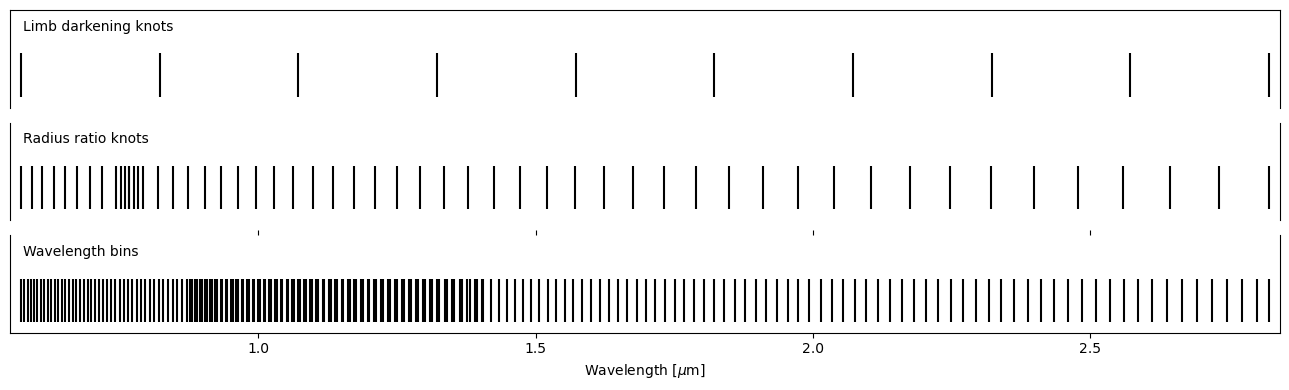

In [30]:
ts = load_model("01a.fits", name='03a')
ts.plot_setup();

### Data setup

Next, let's read in the data as in [Example 1](01a_not_so_short_intro_to_exoiris.ipynb), but bin it to R=300 instead of R=100. We could also skip the binning altogether and use the native data resolution, but this will still be a bit slower, as shown in [Example X]().

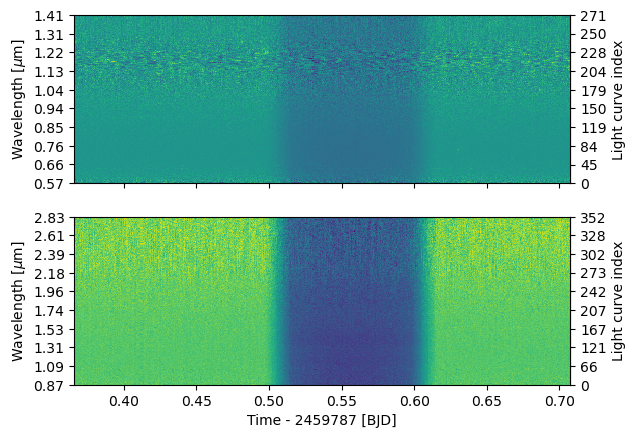

In [31]:
def read_data(fname):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values)

d1 = read_data('data/nirHiss_order_1.h5')
d2 = read_data('data/nirHiss_order_2.h5')
d1.remove_outliers()
d2.remove_outliers()
db = d2.bin_wavelength(r = 300, estimate_errors=True) + d1.bin_wavelength(r = 300, estimate_errors=True)
ax = db.plot()

In [6]:
from numpy import any, isnan, where

In [9]:
where(any(isnan(db.errors), 1))[0]

array([271])

In [32]:
db.errors[271] = db.errors[270]

After which we can simply replace the old data set with the new one using the `ExoIris.set_data` method.

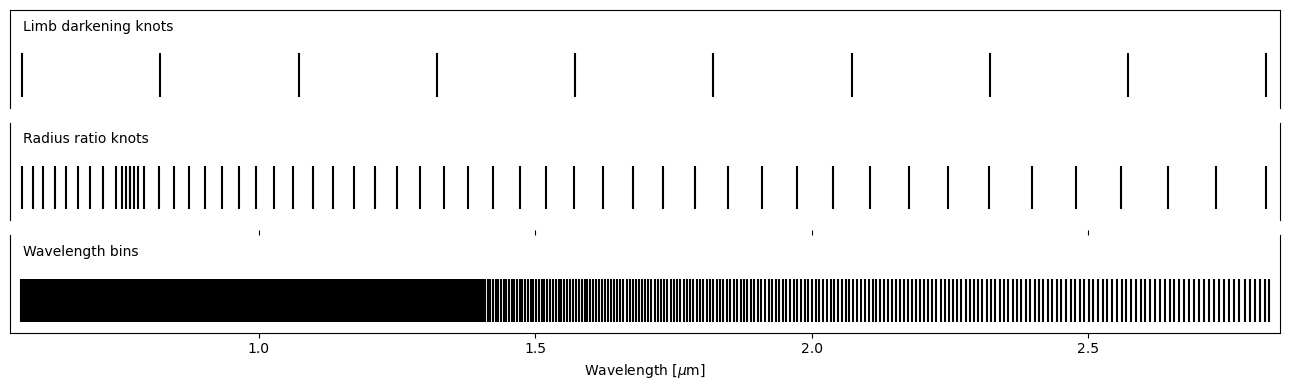

In [33]:
ts.set_data(db)
ts.plot_setup();

And that's it!

We could continue the analysis with a short global optimisation followed by MCMC sampling as in [Example 2](02_increasing_knot_resolution.ipynb), but let's complicate things a bit and also increase our radius ratio knot resolution by combining four knot grids. Note that we can make the start and end points of the grids match because the overlapping knots are cleaned automatically. 

In [34]:
from numpy import c_, r_
knots = r_[geomspace(ts.wavelength[0], 0.768-0.02, 10), 
           linspace(0.768-0.020, 0.768+0.02, 9),
           linspace(0.855-0.055, 0.855+0.055, 13), 
           geomspace(0.855+0.055, ts.wavelength[-1], 120)]

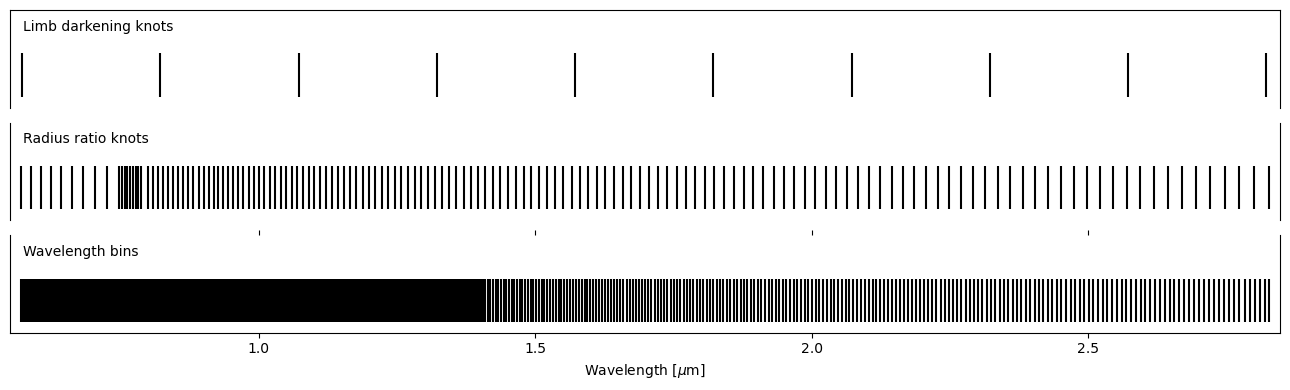

In [35]:
ts.set_radius_ratio_knots(knots)
ts.plot_setup();

### Baseline normalisation

The observational data loaded from [Tutorial 1](01a_not_so_short_intro.ipynb) was already normalised during the original analysis, but the new data isn't. So, we need to start the analysis again by normalising the new data set. 

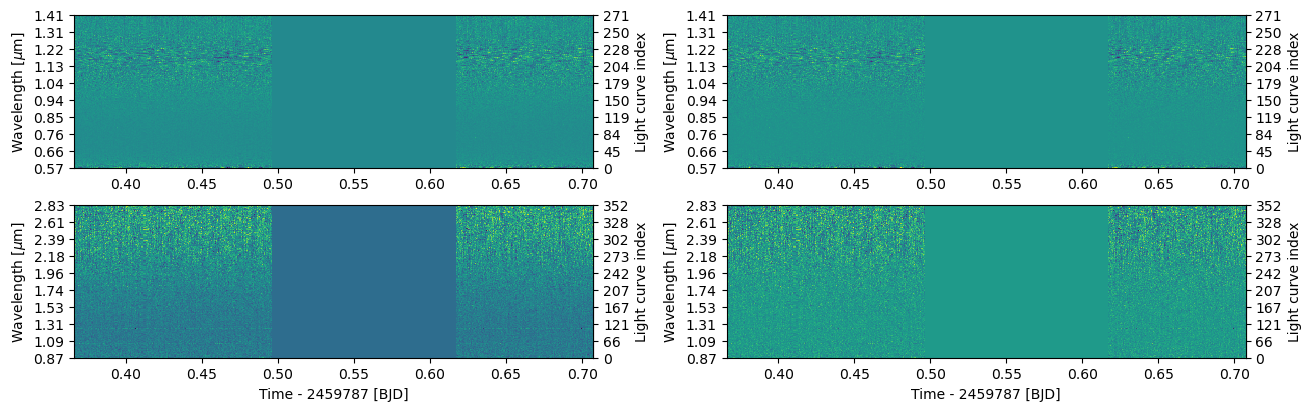

In [36]:
ts.normalize_baseline()
ts.plot_baseline();

## Fitting

Now that the model and data have been set up, we can soon again continue by performing a round of global optimisation and then posterior sampling. First, however, we need to check the number of model parameters, `ts.ndim`. Increasing the data resolution does not increase the model resolution, but increasing the number of radius ratio knots does, and the `emcee` sampler requires that our parameter vector population size (number of walkers in `emcee`) is at least twice the number of model parameters. 

In [37]:
ts._tsa.ndim

176

So, we need a population size of at least 2 x 176 = 352. We create the initial population for the optimiser using the `ExoIris.create_initial_population` method by drawing 400 random parameter vectors from the saved low-resolution model posterior sample and by adding some noise to the population.  

In [38]:
x0 = ts.create_initial_population(400, 'mcmc', add_noise=True)

After which we start the optimisation. Note that the `ExoIris.fit` method has two very similar arguments: `population` and `initial_population`. The difference is that the `population` argument resets the optimiser and starts from the given population, while the `initial_population` is used only if the optimiser hasn't been started yet (or hasn't been reset). This allows you to set the initial population and run the `ExoIris.fit` method multiple times with the same arguments so that each run continues from the previous state (instead of always starting from the `initial_population` what would happen with the `population` argument). 

In [39]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/10 [00:00<?, ?it/s]

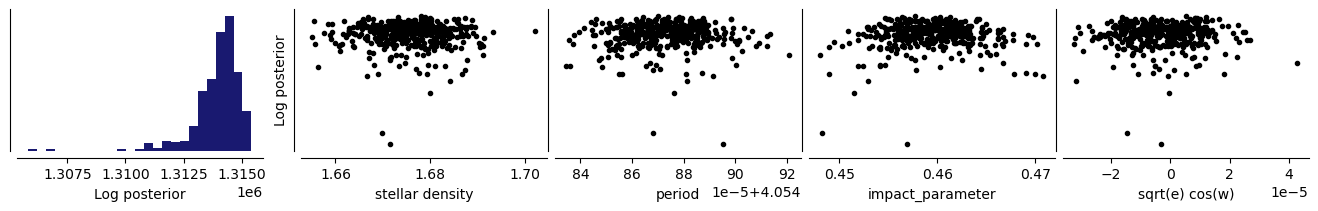

In [41]:
ts.fit(niter=10, pool=pool, lnpost=lnpostf, initial_population=x0)

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

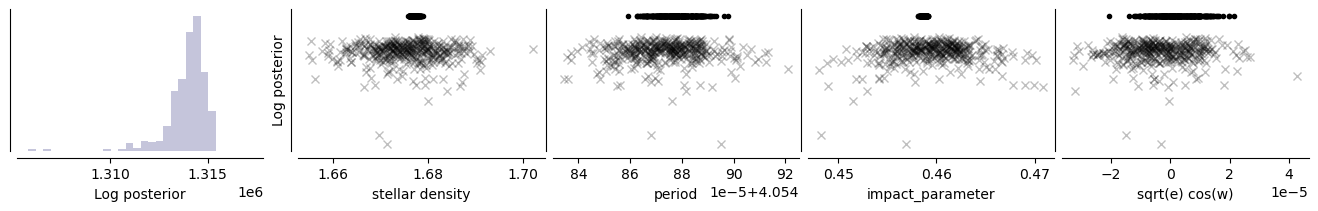

In [42]:
ts.fit(niter=2000, pool=pool, lnpost=lnpostf, initial_population=x0)

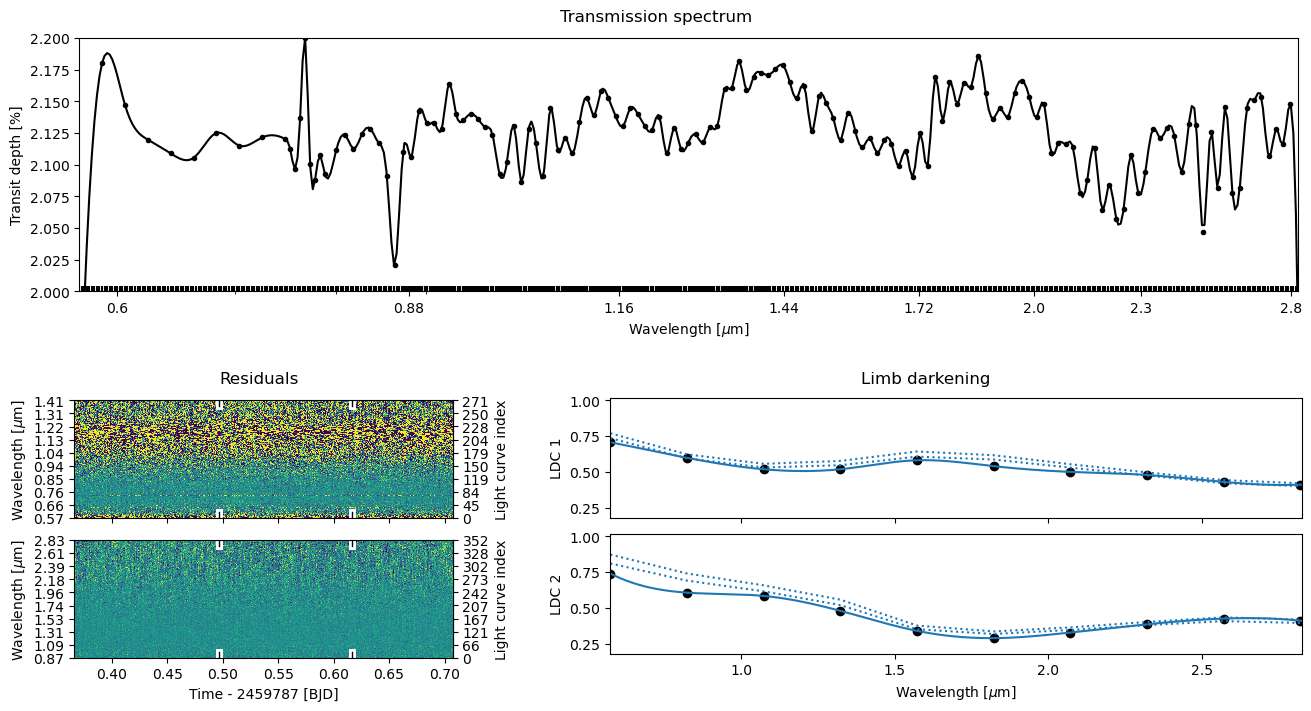

In [43]:
ts.plot_fit('fit', **pargs);

## Posterior sampling

Now we're ready to continue with the posterior sampling. The sampler will automatically start from the parameter vector population clumped by the optimiser if we reset it using the `ExoIris.reset_sampler` method. If we wouldn't do this, it would continue from the low-resolution model posterior sample. In theory, we could skip the optimisation step completely, but it's better to run the optimiser at least for a bit after changing the radius ratio knots.

In [44]:
ts.reset_sampler()

In [45]:
ts.sample(1000, thin=100, repeats=5, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/5 [00:00<?, ?it/s]

Run 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 4/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 5/5:   0%|          | 0/1000 [00:00<?, ?it/s]

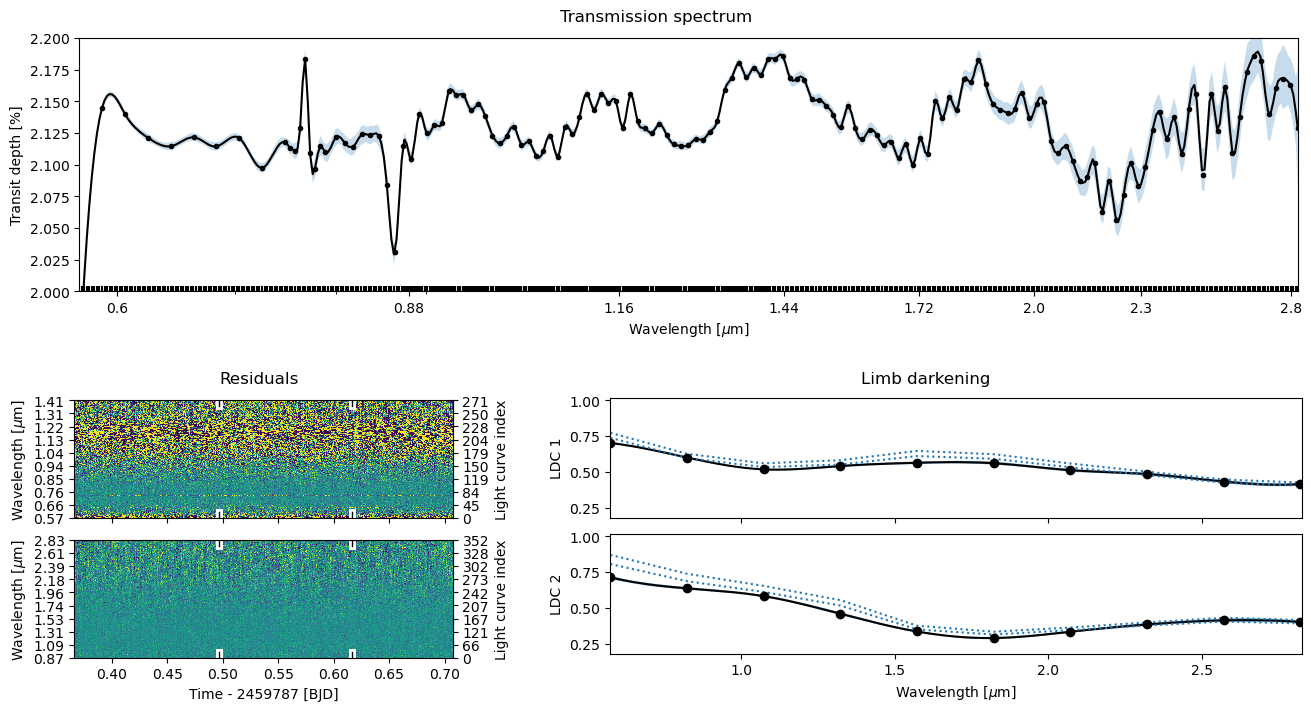

In [24]:
ts.plot_fit(result='mcmc', **pargs);

### Save the results

In [25]:
ts.save(overwrite=True)

---

<center>&copy;2024 Hannu Parviainen</center>